<a href="https://colab.research.google.com/github/jihoon99/transformers/blob/master/2_BertFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# GPU

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU not found')
print(f'Found GPU at : {device_name}')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Found GPU at : /device:GPU:0


'Tesla T4'

In [2]:
!pip install transformers

     |████████████████████████████████| 2.5MB 27.0MB/s 
     |████████████████████████████████| 901kB 49.2MB/s 
     |████████████████████████████████| 3.3MB 45.3MB/s 


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot

# load data set : GLUE

In [4]:
df = pd.read_csv("/content/drive/MyDrive/study/transformer_data/2/in_domain_train.tsv", delimiter='\t', header = None, 
                 names = ['sentence_source','label','label_notes','sentence'])

'''
sentence_source : 문장의 출처
label : 0 - unacceptable, 1 - acceptable
label_notes : 저자가 주석 달아놓은거
sentence : 문장
'''

'\nsentence_source : 문장의 출처\nlabel : 0 - unacceptable, 1 - acceptable\nlabel_notes : 저자가 주석 달아놓은거\nsentence : 문장\n'

In [5]:
df.shape

(8551, 4)

In [6]:
df.sample(10)

,sentence_source,label,label_notes,sentence
5792,c_13,1,NaN,the book of poems with a red cover and with a ...
4572,ks08,0,*,"john seems fond of ice cream , and bill seems ..."
5461,b_73,1,NaN,i have as many marbles too many as you .
5301,b_82,0,*,john ate after getting home the steak .
1429,r-67,0,*,the teacher who that the principal would fire ...
5347,b_73,1,NaN,they think she has too much independence .
8386,ad03,0,*,anson is incredibly difficult to be pleased .
4262,ks08,0,*,seems john to fix the computer .
698,bc01,0,*,john perfectly shot the ball .
2380,l-93,1,NaN,mark terrified me with his single mindedness .


## BERT tokenizer

### add special token CLS, SEP

In [7]:
sentences = df.sentence.values

sentences = ['[CLS] ' + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [8]:
# BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("Tokenize the first sentence : ")
print(tokenized_texts[0])


Tokenize the first sentence : 
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


## PreProcess

In [9]:
max([len(i) for i in tokenized_texts])

47

In [10]:
# 논문에서는 512길이의 토큰을 썻지만 여기서는 128만 쓰겟다, 왜냐면 가장긴 sequence가 47이기 때문이다
MAX_LEN = 128

# Token To Index(BERT index)
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad to my tokens
input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype = 'long', truncating = 'post', padding = 'post')

## Creating Attention Mask

In [11]:
# padding된 부분에 attention되길 원하지 않음. 그래서 attention할때 단어가 있는 부분을 1로 단어가 없는 부분을 0로 맞춰줘야함.
attention_masks = []

# mask 생성
for se in input_ids:
    tmp_mask = [float(i>0) for i in se] # i는 BERT2index 변환 된것이라, 단어가 있으면 1이상의 숫자를 갖음.
    attention_masks.append(tmp_mask)

## Splitting data : train and valid

In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(input_ids, labels, random_state = 42, test_size = 0.1)

mask_train, mask_valid, _, _ = train_test_split(attention_masks, input_ids, random_state = 42, test_size = 0.1)

# Transform to Torch

In [13]:
train_inputs = torch.tensor(x_train)
validation_inputs = torch.tensor(x_valid)
train_labels = torch.tensor(y_train)
validation_labels = torch.tensor(y_valid)
train_masks = torch.tensor(mask_train)
validation_masks = torch.tensor(mask_valid)

## Batch, iterator

In [14]:
BATCH_SIZE = 32

# TensorDataset : Gen, Yield
train_data = TensorDataset(train_inputs, train_masks, train_labels)
print(next(iter(train_data)))

# shuffling
train_sampler = RandomSampler(train_data)

# final dataloader
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)

(tensor([  101,  1996,  2341,  7480,  1010, 14572,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]

In [15]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data) # 순서대로
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = BATCH_SIZE)

# BERT model

In [16]:
try:
    import transformers
except:
    print("install transformer")
    !pip install transformers

from transformers import BertModel, BertConfig


configuration = BertConfig()

# model from 소문자 style configuration
model = BertModel(configuration)

# model
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## Loading Pretrained Model(소문자)

In [17]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Optimizer grouped params
- weight decay - 오버피팅 방지, Bert에서는 bias에게는 적용하지 않는다

In [30]:
#This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']


# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

## hyperparameters for training loop

In [38]:
EPOCHS = 5

optimizer = AdamW(optimizer_grouped_parameters,   # BertAdam 이 AdamW로 대치됨(공식 홈페이지)
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

# 총 학습 횟수는 batch * epoch이다. train_dataloader의 길이로 배치 사이즈를 얻을 수 있다.
total_steps = len(train_dataloader) * EPOCHS

# learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)
# https://huggingface.co/transformers/v1.0.0/model_doc/overview.html

In [39]:
# 정확도 측정 지표
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training Loop

In [51]:
t = []

# loss와 accuracy를 저장
train_loss_set = []

# train for loop
for i in trange(EPOCHS, desc = 'Epoch'):
    
    #0.
    i += 1
    
    #0-1. setting for training
    model.train() # model을 트레이닝 모드로 변경시켜야 한다. == grad가 바뀜
    
    #0-2. varialbe을 트래킹
    tr_loss = 0 # 한번의 epoch마다 total loss를 트래킹
    nb_tr_examples, nb_tr_steps = 0,0



    #1. Training
    for step, batch in enumerate(train_dataloader): # input, mask, label

        #0.
        # GPU에 올리기
        batch = tuple(t.to(device) for t in batch)
        # input, mask, label로 unzip하기
        b_input_ids, b_input_mask, b_labels = batch
        
        #1. forward
        outputs = model(b_input_ids, 
                        token_type_ids = None, # segment part
                        attention_mask=b_input_mask, 
                        labels=b_labels)

        ''' outputs는 아래와 같이 생김.
        SequenceClassifierOutput([('loss',
                                tensor(0.0384, device='cuda:0', grad_fn=<NllLossBackward>)),
                                ('logits', tensor([[-2.5772,  2.9918],
                                        [ 0.7822, -0.1060],
                                        [ 1.4239, -0.8534],
                                        [ 2.1157, -2.2845],
                                        [-2.4045,  3.0784],
                                        [-1.9327,  2.3967],
                                        [-2.4006,  2.7170],
                                        [-2.5830,  2.8918],
                                        [ 2.0901, -2.5894],
                                        [ 2.3376, -2.7502],
                                        [ 1.8533, -1.9293],
                                        [-1.4984,  2.0912],
                                        [ 1.7237, -2.5760],
                                        [-2.2460,  2.6402],
                                        [-2.4833,  2.9084]], device='cuda:0', grad_fn=<AddmmBackward>))])
        ''' 
        
        #2. loss
        loss = outputs['loss']
        train_loss_set.append(loss.item())  #배치당 한번의 로스를 저장함.

        #3-1. reset gradient
        optimizer.zero_grad()

        #3. backward
        loss.backward()

        #4. update weights
        optimizer.step()

        #5. update learning rate
        scheduler.step()

        #6. update tracking variagles
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
    print(f"train loss : {tr_loss/nb_tr_steps}")


    #----------------------------- validation -------------------------

    # setting for valid mode
    model.eval()

    # tracking variables
    eval_loss, eval_accuracy = 0,0
    nb_eval_steps, nb_eval_examples = 0,0

    # evaluation each epoch
    for batch in validation_dataloader:
        #0. Upload batch to gpu
        batch = tuple(t.to(device) for t in batch)
        # input, mask, label로 unzip하기
        b_input_ids, b_input_mask, b_labels = batch

        # gradient업데이트 안하고 계산만한다.
        with torch.no_grad():
            #1. forward
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            
            #2. cpu로 옮김.
            logits = logits['logits'].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            #3. valid accuracy구하기
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            
            #4. 
            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1

    print(f"Validation Accuracy: {eval_accuracy/nb_eval_steps}")


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

train loss : 0.40397073260481425


Epoch:  20%|██        | 1/5 [02:43<10:55, 163.76s/it]

Validation Accuracy: 0.8229166666666666
train loss : 0.235894945817246


Epoch:  40%|████      | 2/5 [05:27<08:10, 163.61s/it]

Validation Accuracy: 0.8194444444444444
train loss : 0.14023110887259863


Epoch:  60%|██████    | 3/5 [08:10<05:26, 163.43s/it]

Validation Accuracy: 0.8113425925925926
train loss : 0.09226074697318414


Epoch:  80%|████████  | 4/5 [10:52<02:43, 163.20s/it]

Validation Accuracy: 0.8275462962962963
train loss : 0.06587267951475634


Epoch: 100%|██████████| 5/5 [13:35<00:00, 163.15s/it]

Validation Accuracy: 0.8287037037037037


# plot

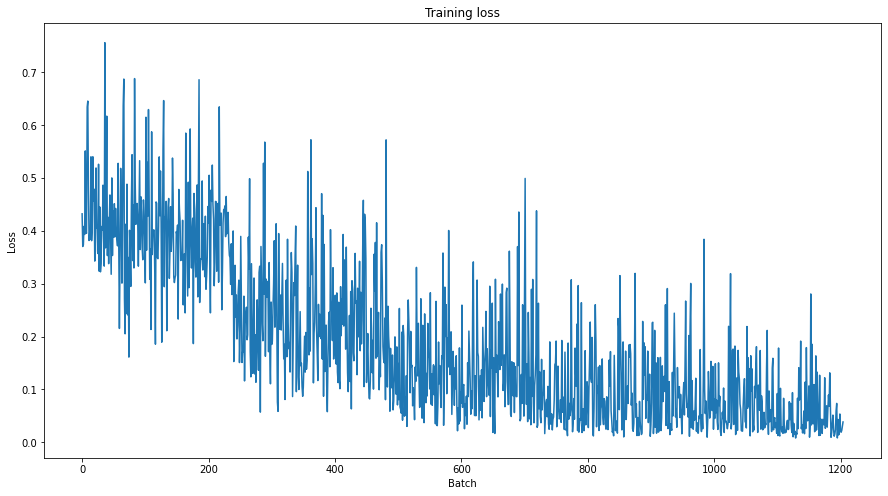

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# Evaluate from out of domain data

## 전처리

In [113]:
# 데이터 로드
df = pd.read_csv("/content/drive/MyDrive/study/transformer_data/2/out_of_domain_dev.tsv", delimiter='\t', 
                 header=None, 
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

# 전처리 : 문장만 모아서 텐서로 만들기전
sentences = df.sentence.values
# Bert에 들어가기 적합한 형태로 변환, CLS, SEP
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

# 타겟값을 텐서로 만들기 적합하게..
labels = df.label.values

# 토크나이즈함. BertTokenizer를 tokenizer로 할당하였음.
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]



MAX_LEN = 128

# Bert tokenizer로 token2idx로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Padding
input_ids = pad_sequences(input_ids, 
                          maxlen=MAX_LEN, 
                          dtype="long", 
                          truncating="post", padding="post")


# Create attention masks
attention_masks = []
# 단어가 있으면 1, 없으면 0(패딩)
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 


# data -> tensor
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  

# 토치로 제너레이터 만들기
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


## Prediction

In [115]:
# evaluation mode : stop gradient
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# 예측
for batch in prediction_dataloader:
    #0. GPU에 올리기
    batch = tuple(t.to(device) for t in batch)
    #0-1. batch를 data, mask, label로 분리
    b_input_ids, b_input_mask, b_labels = batch

    #1. Gradient를 저장 안하게 설정
    with torch.no_grad():
        #1. forward
        logits = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask)

        #2. cpu로 옮기기
        logits = logits['logits'].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #3. 결과물 저장하기
        predictions.append(logits)
        true_labels.append(label_ids)

## Mattew의 Correlation Coefficient로 계산하기

In [116]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
    matthews = matthews_corrcoef(true_labels[i],
                    np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(matthews)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [117]:
matthews_set

[0.049286405809014416,
 -0.050964719143762556,
 0.4732058754737091,
 0.30508307783296046,
 0.3567530340063379,
 0.6777932975034471,
 0.5204358386562267,
 0.29277002188455997,
 0.8320502943378436,
 0.7704873741021288,
 0.9229582069908973,
 0.8333333333333334,
 0.8150678894028793,
 0.647150228929434,
 0.5897435897435898,
 0.49382916465843113,
 0.0]

In [120]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5552516513864393